<a href="https://colab.research.google.com/github/shanikairoshi/DUQFL/blob/main/DQFL_Genome_non_IID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 30 20:39:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:

%%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

In [4]:
%%capture
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit-aer

In [1]:
#-------Split data for federated Setting--------#
num_epochs = 10 #50
max_train_iterations = 100
samples_per_epoch=100 #10
#backend = Aer.get_backend('aer_simulator')
word_size = 40

# Configuration variables
num_clients = 5
num_federated_layers = 10
num_deep_unfolding_iterations = 8
initial_learning_rate = 0.15
meta_learning_rate=1e-4
initial_perturbation = 0.15
momentum = 0.95
gradient_moving_avg = 0

# Define federated learning with accuracy tracking
num_features = 5
global_model_weights, global_model_accuracy = {}, []
clients_train_accuracies, clients_test_accuracies = [], []

# Define the federated learning parameters


Total needed=num_clients×num_epochs×samples_per_epoch
➤ For your configuration:
python
Copy
Edit
num_clients = 8
num_epochs = 10
samples_per_epoch = 100
8
×
10
×
100
=
8000
 training samples needed
8×10×100=8000 training samples needed

In [39]:

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import Aer

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals

# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally


test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)


print(f"Nuber of samples in the test set: {len(test_set)}")
print(f"Nuber of samples in the test set: {len(train_set)}")

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)

from collections import defaultdict
import numpy as np


word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1



print("First sample int the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)


import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]


np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]


np_train_data = np_data_set[:8000]
np_test_data = np_data_set[-1000:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

test_sequences = [data_point["sequence"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)


#---------------------------------------
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import Aer

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals

# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally


test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)


print(f"Number of samples in the test set: {len(test_set)}")
print(f"Number of samples in the train set: {len(train_set)}")

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)

from collections import defaultdict
import numpy as np

word_size = 5 # Define word_size
word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1



print("First sample in the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)


import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)

for i, item in enumerate(np_data_set):
    sequence = item['sequence']
    if len(sequence) < 5:  # If shorter than 5, pad with zeros
        item['sequence'] = np.pad(sequence, (0, 5 - len(sequence)), 'constant', constant_values=0)
    elif len(sequence) > 5:  # If longer than 5, truncate
        item['sequence'] = sequence[:5]

print("First 5 samples of encoded data:")
print(np_data_set[:5])


np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
print(np_data_set[:5])
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
print(np_data_set[:5])


np_train_data = np_data_set[:8000]
np_test_data = np_data_set[-1000:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

test_sequences = [data_point["sequence"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)


#---------------------------------------




Nuber of samples in the test set: 25000
Nuber of samples in the test set: 75000
First sample int the data_set variable: 
('AATGGATAATTTTTTTATTTTTTCAACCAGGAGAATTTCGGTGCAACGAAAACGCATGTGCATTTTGATCTACCTGCATTGCGACAAGCCTTACAGCAACAACGAAGACTGGTCGATTCAAGCTGAAGTACATCTTATTTTGGTTTCAGACACAGGAAGAACATCTACTGATAGGGTCACTCACATTTTCGAAAAACCAG', 0)

First 5 samples in the word_combinations dict.
AATG 1
ATGG 2
TGGA 3
GGAT 4
GATA 5
First 5 samples of encoded data:
First 5 samples of encoded shuffled data:
First 5 samples of scaled encoded shuffled data:
Length of np_train_data: 8000
Length of np_test_data: 1000
Number of samples in the test set: 25000
Number of samples in the train set: 75000
First sample in the data_set variable: 
('AATGGATAATTTTTTTATTTTTTCAACCAGGAGAATTTCGGTGCAACGAAAACGCATGTGCATTTTGATCTACCTGCATTGCGACAAGCCTTACAGCAACAACGAAGACTGGTCGATTCAAGCTGAAGTACATCTTATTTTGGTTTCAGACACAGGAAGAACATCTACTGATAGGGTCACTCACATTTTCGAAAAACCAG', 0)

First 5 samples in the word_combinations dict.
AATGG 1
ATGGA 2
TGGAT 3
GG

In [26]:

'''
def split_dataset(num_clients, num_epochs, samples_per_epoch):
    clients = []
    # Split test data across clients
    test_samples_per_client = len(np_test_data) // num_clients

    for i in range(num_clients):
        client_data = []
        for j in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (j * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((j + 1) * samples_per_epoch)
            client_data.append(np_train_data[start_idx:end_idx])

        # Assign a subset of the test data to each client
        test_start_idx = i * test_samples_per_client
        test_end_idx = (i + 1) * test_samples_per_client
        client_test_data = np_test_data[test_start_idx:test_end_idx]

        # Create Client instance with both train and test data
        clients.append(Client(client_data, client_test_data))

    return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)

# Verify test data distribution across clients
for index, client in enumerate(clients):
    print(f"Client {index} Test Data Length: {len(client.test_data)}")
    clients = []
    # Split test data across clients
    test_samples_per_client = len(np_test_data) // num_clients

    for i in range(num_clients):
        client_data = []
        for j in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (j * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((j + 1) * samples_per_epoch)
            client_data.append(np_train_data[start_idx:end_idx])

        # Assign a subset of the test data to each client
        test_start_idx = i * test_samples_per_client
        test_end_idx = (i + 1) * test_samples_per_client
        client_test_data = np_test_data[test_start_idx:test_end_idx]

        # Create Client instance with both train and test data
        clients.append(Client(client_data, client_test_data))

    return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)

# Verify test data distribution across clients
for index, client in enumerate(clients):
    print(f"Client {index} Test Data Length: {len(client.test_data)}")
'''

'\ndef split_dataset(num_clients, num_epochs, samples_per_epoch):\n    clients = []\n    # Split test data across clients\n    test_samples_per_client = len(np_test_data) // num_clients\n\n    for i in range(num_clients):\n        client_data = []\n        for j in range(num_epochs):\n            start_idx = (i * num_epochs * samples_per_epoch) + (j * samples_per_epoch)\n            end_idx = (i * num_epochs * samples_per_epoch) + ((j + 1) * samples_per_epoch)\n            client_data.append(np_train_data[start_idx:end_idx])\n\n        # Assign a subset of the test data to each client\n        test_start_idx = i * test_samples_per_client\n        test_end_idx = (i + 1) * test_samples_per_client\n        client_test_data = np_test_data[test_start_idx:test_end_idx]\n\n        # Create Client instance with both train and test data\n        clients.append(Client(client_data, client_test_data))\n\n    return clients\n\nclients = split_dataset(num_clients, num_epochs, samples_per_epoch)\n\n#

In [43]:
labels = set()
for sample in np_train_data:
    labels.add(sample['label'])

print(f"Number of unique labels: {len(labels)}")
print(f"Labels: {labels}")


Number of unique labels: 2
Labels: {0, 1}


In [40]:
from scipy.special import rel_entr

def kl_divergence(p, q):
    p = np.asarray(p, dtype=np.float32)
    q = np.asarray(q, dtype=np.float32)
    return np.sum(rel_entr(p, q))

def label_distribution(client):
    labels = [sample['label'] for epoch in client.data for sample in epoch]
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    dist = [label_counts.get(i, 0) / total for i in range(len(set(label_counts)))]
    return dist

for i in range(len(clients)):
    for j in range(i + 1, len(clients)):
        dist_i = label_distribution(clients[i])
        dist_j = label_distribution(clients[j])
        kl_ij = kl_divergence(dist_i, dist_j)
        kl_ji = kl_divergence(dist_j, dist_i)
        print(f"KL(Client {i} || Client {j}) = {kl_ij:.4f}, KL(Client {j} || Client {i}) = {kl_ji:.4f}")


KL(Client 0 || Client 1) = 0.0000, KL(Client 1 || Client 0) = 0.0000
KL(Client 0 || Client 2) = 0.0000, KL(Client 2 || Client 0) = 0.0000
KL(Client 0 || Client 3) = 0.0018, KL(Client 3 || Client 0) = 0.0018
KL(Client 0 || Client 4) = 0.0000, KL(Client 4 || Client 0) = 0.0000
KL(Client 1 || Client 2) = 0.0001, KL(Client 2 || Client 1) = 0.0001
KL(Client 1 || Client 3) = 0.0015, KL(Client 3 || Client 1) = 0.0015
KL(Client 1 || Client 4) = 0.0001, KL(Client 4 || Client 1) = 0.0001
KL(Client 2 || Client 3) = 0.0022, KL(Client 3 || Client 2) = 0.0022
KL(Client 2 || Client 4) = 0.0000, KL(Client 4 || Client 2) = 0.0000
KL(Client 3 || Client 4) = 0.0020, KL(Client 4 || Client 3) = 0.0021


We apply partial label skew here

In [46]:
'''
def split_dataset_partial_label_skew(num_clients, major_label_ratio=0.8, samples_per_client=1000):
    from collections import defaultdict
    import random

    # Separate training data by label
    label_buckets = defaultdict(list)
    for sample in np_train_data:
        label_buckets[sample['label']].append(sample)

    # Shuffle each label bucket
    for label in label_buckets:
        random.shuffle(label_buckets[label])

    clients = []
    labels = list(label_buckets.keys())

    for i in range(num_clients):
        major_label = labels[i % len(labels)]  # Assign majority label per client
        minor_label = labels[(i + 1) % len(labels)]  # Other label

        num_major = int(major_label_ratio * samples_per_client)
        num_minor = samples_per_client - num_major

        # Sample data
        major_samples = label_buckets[major_label][:num_major]
        minor_samples = label_buckets[minor_label][:num_minor]

        # Remove assigned samples from the buckets
        label_buckets[major_label] = label_buckets[major_label][num_major:]
        label_buckets[minor_label] = label_buckets[minor_label][num_minor:]

        client_data = major_samples + minor_samples
        random.shuffle(client_data)

        # Assign test data (can be IID)
        test_data = np_test_data[i * 500:(i + 1) * 500]

        clients.append(Client(data=[client_data], test_data=test_data))

    return clients
'''

In [41]:
from collections import defaultdict
import random

class Client:  # Define the Client class
    def __init__(self, data, test_data):
        self.data = data
        self.test_data = test_data
        self.primary_model = None  # Add primary_model attribute



def split_dataset_label_skew(num_clients):
    # Separate by label
    label_buckets = defaultdict(list)
    for sample in np_train_data:
        label_buckets[sample['label']].append(sample)

    # Shuffle each bucket
    for label in label_buckets:
        random.shuffle(label_buckets[label])

    clients = []
    labels = list(label_buckets.keys())

    # Assign specific label(s) to each client
    for i in range(num_clients):
        label_to_use = labels[i % len(labels)]  # e.g., alternate between 0 and 1
        client_data = label_buckets[label_to_use][:1000]  # pick 1000 samples of that label
        label_buckets[label_to_use] = label_buckets[label_to_use][1000:]  # remove assigned

        # Sample test data (could remain IID)
        test_data = np_test_data[i * 500:(i + 1) * 500]
        clients.append(Client(data=[client_data], test_data=test_data))

    return clients


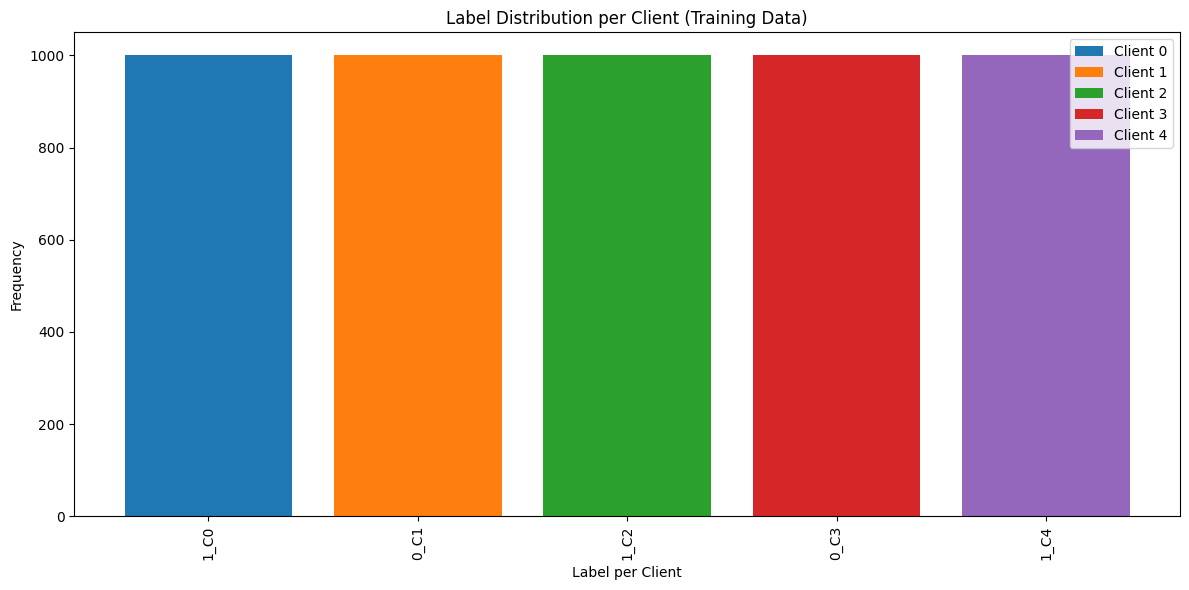

In [42]:
import matplotlib.pyplot as plt
from collections import Counter

clients = split_dataset_label_skew(num_clients)

def plot_label_distribution(clients):
    plt.figure(figsize=(12, 6))
    for idx, client in enumerate(clients):
        labels = [sample['label'] for epoch in client.data for sample in epoch]
        label_counts = Counter(labels)
        labels_sorted = sorted(label_counts.keys())
        counts = [label_counts[label] for label in labels_sorted]

        plt.bar(
            [str(label) + f"_C{idx}" for label in labels_sorted],
            counts,
            label=f'Client {idx}'
        )

    plt.xlabel("Label per Client")
    plt.ylabel("Frequency")
    plt.title("Label Distribution per Client (Training Data)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_label_distribution(clients)


Data Load and preprocessing

In [43]:
def split_dataset_for_epochs(num_clients, num_epochs, train_data, test_data, samples_per_epoch):
    """
    Split the dataset across multiple epochs and clients.

    Args:
        num_clients (int): Number of clients.
        num_epochs (int): Number of epochs.
        train_data (list): List of training data points.
        test_data (list): List of test data points.
        samples_per_epoch (int): Number of samples per epoch.

    Returns:
        list: A list of Client objects with assigned data for each epoch.
    """
    clients = []

    # Split the training data across epochs and clients
    train_samples_per_client = len(train_data) // num_clients

    for i in range(num_clients):
        client_data_for_epochs = []

        for epoch in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (epoch * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((epoch + 1) * samples_per_epoch)
            client_data_for_epochs.append(train_data[start_idx:end_idx])

        # Assign test data to each client
        test_samples_per_client = len(test_data) // num_clients
        test_start_idx = i * test_samples_per_client
        test_end_idx = (i + 1) * test_samples_per_client
        client_test_data = test_data[test_start_idx:test_end_idx]

        # Create a Client instance with epoch-specific data
        clients.append(Client(client_data_for_epochs, client_test_data))

    return clients


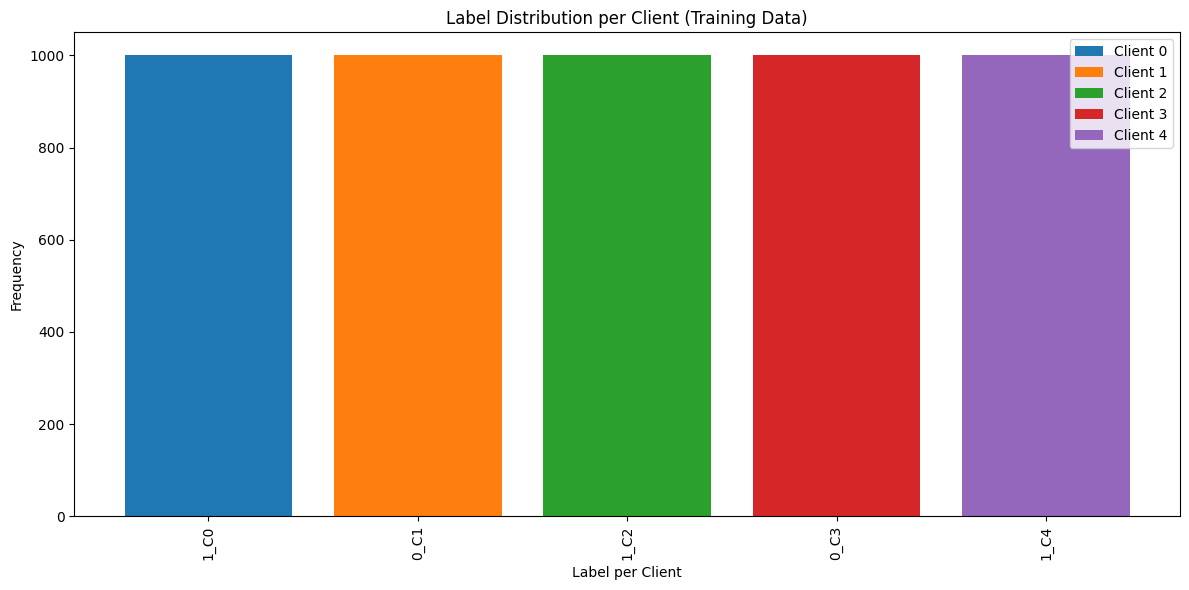

In [44]:
import matplotlib.pyplot as plt
from collections import Counter

#clients = split_dataset_label_skew(num_clients)

def plot_label_distribution(clients):
    plt.figure(figsize=(12, 6))
    for idx, client in enumerate(clients):
        labels = [sample['label'] for epoch in client.data for sample in epoch]
        label_counts = Counter(labels)
        labels_sorted = sorted(label_counts.keys())
        counts = [label_counts[label] for label in labels_sorted]

        plt.bar(
            [str(label) + f"_C{idx}" for label in labels_sorted],
            counts,
            label=f'Client {idx}'
        )

    plt.xlabel("Label per Client")
    plt.ylabel("Frequency")
    plt.title("Label Distribution per Client (Training Data)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_label_distribution(clients)


In [46]:

import csv
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss
from tqdm import tqdm


# Callback function to capture the loss values
objective_func_vals = []  # Global list to store loss values
learning_rates = []
perturbations = []
# Data structure for tracking per-client, per-layer objective function values


In [47]:

import os  # For handling directories

# Define the directory to save the plots
output_dir = "federated_round_plots"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Initialize a global variable to track the round number
current_round = 1

# Callback for visualization, gradient smoothing, and learning rate adjustment in deep unfolding
def deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients=None,round_number=0):
    global gradient_moving_avg, learning_rates, perturbations,current_round

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # If gradients are provided, smooth the gradient using momentum
    if gradients is not None:
        gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients  # Apply moving average
        delta_lr = 0.05 * gradient_moving_avg  # Adjust learning rate based on the smoothed gradient
        delta_perturbation = 0.1 * gradient_moving_avg  # Adjust perturbation based on the same gradient
    else:
        delta_lr = 0  # No gradient info available in this iteration
        delta_perturbation = 0

    # Update learning rate and perturbation
    if len(learning_rates) > 0:
        new_lr = max(0.001, learning_rates[-1] + delta_lr)  # Ensure learning rate is positive and non-zero
        new_perturbation = max(0.001, perturbations[-1] + delta_perturbation)  # Ensure perturbation is positive
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    import matplotlib.pyplot as plt

    # Visualization of learning rate and perturbation
    plt.figure(figsize=(10, 12))  # Adjust figure size for better spacing

    # Plot Objective Function Value
    plt.subplot(3, 1, 1)
    plt.plot(range(len(objective_func_vals)), objective_func_vals, label="Objective Function Value", color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title("Objective Function Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)  # Add grid for better readability

    # Plot Learning Rate
    plt.subplot(3, 1, 2)
    plt.plot(range(len(learning_rates)), learning_rates, label="Learning Rate", color='green')
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    # Plot Perturbation
    plt.subplot(3, 1, 3)
    plt.plot(range(len(perturbations)), perturbations, label="Perturbation", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.title("Perturbation Over Iterations")
    plt.legend(loc="best")
    plt.grid(True)

    plt.tight_layout(pad=3.0)  # Add padding between subplots
    # Save the plot after each federated round
    #plot_filename = os.path.join(output_dir, f"federated_round_{current_round}.png")
    #plt.savefig(plot_filename)  # Save the figure
    #plt.show()
    plt.close()  # Close the plot to free memory

    # Increment the round number for the next call
    current_round += 1


# Define the SPSA callback to capture gradients and update learning rate and perturbation dynamically
def spsa_callback(nfev, parameters, obj_func_eval, stepsize, accept):
    # Assuming `stepsize` contains gradient information or its approximation
    gradients = stepsize
    deep_unfolding_learning_rate_adjustment(parameters, obj_func_eval, gradients)

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=1e-4, initial_perturbation=0.01, lr_alpha=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr  # Initial learning rate
        self.perturbation = initial_perturbation  # Initial perturbation
        self.lr_alpha = lr_alpha  # Learning rate and perturbation update speed

    def _update_learning_rate_and_perturbation(self, gradient, obj_func_eval):
        """
        Update both learning rate and perturbation based on gradient and objective function evaluation.
        The learning rate increases if the objective function improves and decreases otherwise.
        """
        # Use the gradient sign to determine if we should increase or decrease
        grad_lr = np.sign(np.mean(gradient))  # Average gradient sign across parameters

        if grad_lr > 0:  # Objective function is improving
            self.lr += self.lr_alpha * abs(grad_lr)  # Increase learning rate
            self.perturbation += self.lr_alpha * abs(grad_lr)  # Increase perturbation
        else:  # Objective function is getting worse
            self.lr -= self.lr_alpha * abs(grad_lr)  # Decrease learning rate
            self.perturbation -= self.lr_alpha * abs(grad_lr)  # Decrease perturbation

        # Ensure both learning rate and perturbation are positive
        self.lr = max(0.001, self.lr)
        self.perturbation = max(0.001, self.perturbation)

    def step(self, gradient, obj_func_eval):
        """
        Perform optimization step for both parameters, learning rate, and perturbation.
        Use the objective function evaluation to dynamically adjust learning rate and perturbation.
        """
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)  # Perform SPSA step for parameters

    def reset(self):
        """
        Reset the optimizer state (learning rates, perturbations, and gradient moving averages) for the next round.
        """
        self.lr = initial_learning_rate
        self.perturbation = initial_perturbation
        self.gradient_moving_avg = 0  # Reset the moving average of the gradient
        learning_rates.clear()  # Reset the learning rates history
        perturbations.clear()  # Reset the perturbations history
        objective_func_vals.clear()  # Clear the objective function history

In [48]:
# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
      maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)

In [49]:

#======================================================
# Initialize QNN model
def initialize_model(num_features,initial_params):
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    qc = feature_map.compose(ansatz)

    # Create optimizer with learnable learning rate and perturbation
    spsa_optimizer = LearnableLRPerturbationSPSA(
      maxiter=20, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=spsa_callback, lr_alpha=0.01
)
    def parity(x):
        return "{:b}".format(x).count("1") % 2

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )


    # Define the neural network classifier
    qnn_classifier = NeuralNetworkClassifier(
      neural_network=sampler_qnn,
      optimizer=spsa_optimizer,
      loss='squared_error',
      initial_point=initial_params,  # Initialize with the starting parameters
)


    return qnn_classifier

#=====================================================
from google.colab import drive
import csv
# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the save path in Google Drive
csv_file = '/content/drive/My Drive/DQFL_Genome__non-IID_31_03_2025v1.csv'

# Step 3: Define headers for the CSV
headers = ["Federated Round", "Client Number", "Iteration", "Objective Function Value",
           "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"]

# Open the CSV file and write headers if it's the first time writing to the file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)

# Example of saving results for each federated round and client
def save_results(federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation):
    with open(csv_file, mode='a', newline='') as file:  # Open file in append mode
        writer = csv.writer(file)
        writer.writerow([federated_round, client_id, iteration, obj_func_val, train_acc, test_acc, learning_rate, perturbation])
#=====================================================
# Federated learning loop per client
def train_qnn_model(client_data, client_test_data, model=None, client_id=None, layer=None):

    global learning_rates, perturbations, objective_func_vals
    print("Client Data Structure:")  # Add this line to print the structure
    print(client_data)                # This line prints the actual data
    print(type(client_data))           # This line prints the data type
    #num_features = client_data[0]["sequence"].shape[0]

    #initial_params = np.random.rand(RealAmplitudes(client_data.shape[1], reps=4).num_parameters)  # Initialize params
    initial_params = np.random.rand(RealAmplitudes(len(client_data[0]["sequence"]), reps=3).num_parameters)

    if model is None:
        model = initialize_model(num_features, initial_params)

    train_sequences = np.array([data_point["sequence"] for data_point in client_data])

    # Check if train_sequences has the correct shape
    if train_sequences.shape[1] != num_features:  # Ensure num_features is 5
        raise ValueError(f"Input data shape incorrect. Expected {num_features} features, got {train_sequences.shape[1]}.")

    train_labels = np.array([data_point["label"] for data_point in client_data])
    test_sequences = np.array([data_point["sequence"] for data_point in client_test_data])
    test_labels = np.array([data_point["label"] for data_point in client_test_data])

    train_accuracies, test_accuracies, total_time = [], [], 0

    train_accuracies = []
    test_accuracies = []

    # Deep Unfolding with multiple iterations
    # Continue training with learned weights and adjust learning rate based on performance and gradients.
    total_time = 0
    current_params = initial_params  # Start with the initial parameters

    for i in range(num_deep_unfolding_iterations):
        print("\n")
        print(f"Deep Unfolding Iteration {i+1}/{num_deep_unfolding_iterations}")
        start_time = time.time()
        model.fit(train_sequences, train_labels)
        end_time = time.time()
        total_time += end_time - start_time

        # After training, retrieve the updated parameters from the optimizer
        current_params = model.weights
        print(f"Trained parameters after iteration {i+1}: {current_params}")

        # Store final weights and learning rate for next round
        final_learning_rate = learning_rates[-1]
        final_perturbation = perturbations[-1]

        # Evaluate the model performance
        train_accuracy = model.score(train_sequences, train_labels)
        test_accuracy = model.score(test_sequences, test_labels)

        # Store accuracies for future reference
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)


        # Write the results to the CSV file
        save_results(layer, client_id, i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation)

        #with open(csv_file, mode='a', newline='') as file:
          #writer = csv.writer(file)
         #writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])

        # Update the learning rate for the next iteration based on gradients from SPSA
        spsa_optimizer.learning_rate = learning_rates[-1]
        model.initial_point = current_params

        # Log performance
        print(f"Iteration {i+1} - Learning Rate: {final_learning_rate:.6f}")
        print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    return model, train_accuracy, train_accuracy, total_time




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
# Step to empty the CSV file before starting a new run
def clear_csv_file():
    """
    Clears the CSV file by overwriting it with headers or leaving it blank.
    """
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Uncomment the next line to write headers for the new run
        writer.writerow(headers)
        # Leave it blank if you prefer not to include headers
        # pass



In [51]:
def get_accuracy(model, test_sequences, test_labels):
    """
    Evaluate the accuracy of the given model on the test dataset.

    Parameters:
        model: The trained model to evaluate.
        num_features: The number of features in each data sample.
        test_sequences: A list or array of test input data (features).
        test_labels: A list or array of true labels corresponding to the test data.

    Returns:
        float: The accuracy of the model as a percentage.
    """
    test_accuracy = model.score(test_sequences, test_labels)
    return test_accuracy

# Function to extract numerical values of parameters
def extract_param_values(model):
    #param_values = []
    # Loop through each parameter in the circuit and get its bound value
    # Retrieve the circuit from the neural network
    circuit = model.neural_network.circuit

    # Extract the parameter values bound to the circuit
    # Use enumerate to get both index and parameter
    param_values = {param: circuit.parameters[i] for i, param in enumerate(circuit.parameters)}
    return param_values
#def set_param_values(model, param_values):
    # Retrieve the circuit from the neural network
    #circuit = model.neural_network.circuit

    # Use assign_parameters to update the parameter values
    #circuit.assign_parameters(param_values, inplace=True)
# Function to set numerical values of parameters back into the circuit
def set_param_values(model, param_values):
    # Assign the averaged parameter values back to the circuit
    parameter_dict = {param: value for param, value in zip(model.neural_network.circuit.parameters, param_values)}
    model.neural_network.circuit.assign_parameters(parameter_dict)


# Manually average the numerical values of the parameters across clients
def manual_average_weights(epoch_weights):
    # Initialize a list to store the summed weights (initialize with zeros)
    num_weights = len(epoch_weights[0])  # Number of weights in the model
    num_clients = len(epoch_weights)  # Number of clients

    # Initialize sum of weights to zero (assuming NumPy array or list of weights)
    summed_weights = np.zeros(num_weights)

    # Sum the weights from all clients
    for client_weights in epoch_weights:
        summed_weights += np.array(client_weights)

    # Compute the average by dividing the summed weights by the number of clients
    average_weights = summed_weights / num_clients

    return average_weights

def create_model_with_weights(weights):
    initial_params = np.random.rand(RealAmplitudes(num_features, reps=3).num_parameters)
    model = initialize_model(num_features,weights)
    #set_param_values(model, weights)  # Assign global weights to the model
    return model


In [30]:

# Function to save accuracies to CSV
def save_accuracies_to_csv(global_accuracies, clients_train_accuracies, clients_test_accuracies, filename='accuracies.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        header = ['Epoch', 'Global Accuracy']
        for i in range(len(clients_train_accuracies[0])):  # Assuming all clients have the same number of records
            header.append(f'Client {i} Train Accuracy')
            header.append(f'Client {i} Test Accuracy')
        writer.writerow(header)

        # Write the accuracy data for each epoch
        for epoch in range(len(global_accuracies)):
            row = [epoch, global_accuracies[epoch]]  # Start with epoch and global accuracy
            for client_index in range(len(clients_train_accuracies[epoch])):
                row.append(clients_train_accuracies[epoch][client_index])  # Add train accuracy for client
                row.append(clients_test_accuracies[epoch][client_index])   # Add test accuracy for client
            writer.writerow(row)


Federated Learning Setup

In [1]:

clients = split_dataset_for_epochs(num_clients, num_epochs, np_train_data, np_test_data, samples_per_epoch)

import matplotlib.pyplot as plt
from collections import Counter


def plot_label_distribution(clients):
    plt.figure(figsize=(12, 6))
    for idx, client in enumerate(clients):
        labels = [sample['label'] for epoch in client.data for sample in epoch]
        label_counts = Counter(labels)
        labels_sorted = sorted(label_counts.keys())
        counts = [label_counts[label] for label in labels_sorted]

        plt.bar(
            [str(label) + f"_C{idx}" for label in labels_sorted],
            counts,
            label=f'Client {idx}'
        )

    plt.xlabel("Label per Client")
    plt.ylabel("Frequency")
    plt.title("Label Distribution per Client (Training Data)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_label_distribution(clients)


# Display information about the data assigned to each client, including epoch-wise splits
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    for epoch in range(num_epochs):
        print(f"  Epoch {epoch + 1}: Train data samples: {len(client.data[epoch])}")
    print(f"  Test data samples: {len(client.test_data)}")

# Display information about the data assigned to each client
#for idx, client in enumerate(clients):
    #print(f"Client {idx + 1}:")
    #print(f"  Train data samples: {len(client.data)}")
    #print(f"  Test data samples: {len(client.test_data)}")

    # Accessing the number of features in a sequence
    if client.data:
        #num_features=client.data[0][0]['sequence'].shape[0]  # Access first data point of epoch 0
        #num_features = client.data[0]['sequence'].shape[0]
        print(f"  Number of features in a sequence: {num_features}")

def reset_state():
    # Reset the objective value, learning rate, and perturbation after each client
    global objective_func_vals, learning_rates, perturbations
    objective_func_vals = []  # Reset objective values
    learning_rates = []  # Reset learning rates
    perturbations = []  # Reset perturbations
# Function to reset callback graph state after each round
def reset_callback_graph():
    global gradient_moving_avg, learning_rates, perturbations

    # Reset the state variables to start fresh for the next round
    gradient_moving_avg = np.zeros_like(gradient_moving_avg)  # Reset gradient moving average
    learning_rates = [initial_learning_rate]  # Reset learning rates list to initial value
    perturbations = [initial_perturbation]  # Reset perturbations list to initial value
import csv

# Path to store the best client's data
best_client_csv_file = '/content/drive/My Drive/Best_Client_DQFL_Genome__non-IID_31_03_2025.csv'

# Write headers to the best client CSV file
best_headers = ["Federated Round", "Client Number"]

with open(best_client_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(best_headers)

# Function to update the best client data
def save_best_client_results(federated_round,best_client_index):
    """
    Save the best client's data to a separate CSV file.
    :param best_data: Dictionary containing the best client's data.
    """
    with open(best_client_csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([federated_round,
           best_client_index

        ])
# Clear the CSV file for a new run
clear_csv_file()

# Wrap the epoch loop with tqdm
for epoch in tqdm(range(num_federated_layers), desc="Training Progress"):
    global_model_weights[epoch] = []
    epoch_train_accuracies, epoch_test_accuracies = [], []
    best_client_index = -1
    best_client_accuracy = -1
    best_client_model = None
    print("\n")
    print(f"Fed_Epoch: {epoch}")

    for index, client in enumerate(clients):
        print("\n")
        print(f"Fed_Epoch {epoch}, Client {index + 1}:")
        reset_state()

        try:
            # Ensure you're using the correct index for data
            current_data = client.data[epoch]  # This assumes data is structured in epochs
            print(f"Training data for epoch {epoch}: {len(current_data)}")
        except IndexError:
            print(f"No data available for epoch {epoch} for Client {index + 1}")
            continue  # Skip this client for the current epoch

        model, train_score, test_score, train_time = train_qnn_model(
            client.data[epoch],
            client.test_data,
            client_id=index,
            layer=epoch,
        )

        epoch_train_accuracies.append(train_score)
        epoch_test_accuracies.append(test_score)

        # Check if this client has the best accuracy so far
        if test_score > best_client_accuracy:
            best_client_accuracy = test_score
            best_client_index = index
            best_client_model = model  # Directly store the best client's model

    save_best_client_results(epoch,best_client_index)  # Save to best client CSV
    print(f"Best client for epoch {epoch} is Client {best_client_index + 1} with test accuracy {best_client_accuracy:.2f}")

    # Treat the best client's model as the global model for the next round
    global_model = best_client_model

    # Update all clients with the global model
    for index, client in enumerate(clients):
        client.primary_model = global_model

    # Evaluate the global model on the new test data
    global_accuracy = get_accuracy(global_model, test_sequences, test_labels)
    global_model_accuracy.append(global_accuracy)

    clients_train_accuracies.append(epoch_train_accuracies)
    clients_test_accuracies.append(epoch_test_accuracies)

    print(f"Global Model Accuracy in Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


    # Save results for the current iteration of the client in the federated round
    from google.colab import drive

    # Step 1: Mount Google Drive
    drive.mount('/content/drive')

    # Step 2: Define the save path in Google Drive
    save_path = '/content/drive/MyDrive/DQFL_Genome__non-IID_Global_31_03_2025.csv'


    # Save accuracies to CSV after each epoch (or at the end of all epochs)
    save_accuracies_to_csv(global_model_accuracy, clients_train_accuracies, clients_test_accuracies, filename=save_path)
    # After each round, reset callback state to prepare for the next round
    reset_callback_graph()
    print(f"File saved to {save_path}")

#print("Accuracy data saved to", csv_file_path)


NameError: name 'split_dataset_for_epochs' is not defined

Split data as iid and non-iid

In [ ]:


#Introduce custome cross entropy function
import numpy as np

# Callback for updating learning rate dynamically with deep unfolding principles
def deep_unfolding_learning_rate_adjustment(obj_func_eval, gradients=None, client_id=None, layer=None):
    global gradient_moving_avg, learning_rates, perturbations,meta_alpha, meta_epsilon, momentum

    # Initialize moving average for gradients
    if gradients is not None:
        if not isinstance(gradient_moving_avg, np.ndarray) or gradient_moving_avg.size == 0:
            gradient_moving_avg = gradients
        else:
            # Update moving average of gradients (Momentum)
            gradient_moving_avg = momentum * gradient_moving_avg + (1 - momentum) * gradients
        # Calculate the average gradient
        avg_gradient = np.mean(gradient_moving_avg)

        # Normalize delta_lr by L2 norm of the gradient
        norm_gradient = np.linalg.norm(gradients)

        '''
        # Normalization to prevent instability
        norm_gradient = gradients / (np.linalg.norm(gradients) + 1e-8)
        avg_gradient = np.mean(norm_gradient)
        '''
        # Trainable scaling for deep unfolding (meta-parameter)
        meta_alpha = 0.01  # This can be learned via a hypernetwork or meta-learning
        meta_epsilon = 1e-6  # Small offset to ensure numerical stability
        # Gradually adjust learning rate based on gradient signs and magnitude
        # This formula gradually adds or subtracts from the learning rate instead of multiplication
        delta_lr = meta_alpha * np.sign(avg_gradient) * np.sqrt(np.abs(avg_gradient) + meta_epsilon) / (norm_gradient + 1e-6)

        #delta_lr = meta_alpha * np.sign(avg_gradient) * np.sqrt(np.abs(avg_gradient) + meta_epsilon)
    # Apply gradual adjustment (either addition or subtraction based on the direction of the gradient)
        if avg_gradient > 0:
            delta_lr = delta_lr - 0.001  # Decrease if gradient is positive (potential overfitting)
        else:
            delta_lr = delta_lr + 0.001  # Increase if gradient is negative (potential underfitting)
    else:
        delta_lr = 0

    # Compute new learning rate with clamping for stability
    new_lr = max(0.001, min(5.0, learning_rates[-1] + delta_lr)) if learning_rates else initial_learning_rate

    # Update per-client, per-layer information if federated
    if client_id is not None and layer is not None:
        if client_id not in client_data:
            client_data[client_id] = {'federated_layers': {}}
        if layer not in client_data[client_id]['federated_layers']:
            client_data[client_id]['federated_layers'][layer] = {'objective_values': [], 'learning_rates': []}

        # Store loss and learning rate for the specific client and layer
        client_data[client_id]['federated_layers'][layer]['objective_values'].append(obj_func_eval)
        client_data[client_id]['federated_layers'][layer]['learning_rates'].append(new_lr)

    # Store global metrics
    objective_func_vals.append(obj_func_eval)  # Store the loss value globally
    learning_rates.append(new_lr)  # Append the new learning rate to the history

    # Update meta-parameters (meta_alpha and meta_epsilon) using gradient descent
    #meta_gradients = compute_meta_gradients(gradients, avg_gradient, delta_lr)
    #meta_alpha -= meta_learning_rate * meta_gradients['alpha']
    #meta_epsilon -= meta_learning_rate * meta_gradients['epsilon']

    # Debug output for analysis
    # print(f"Objective Function Value: {obj_func_eval:.6f}, New Learning Rate: {new_lr:.6f}")

    return new_lr


def callback_graph(weights, loss):
    """Callback to log and synchronize loss during training."""
    #print(f"Loss = {loss}")
    if len(objective_func_vals) == 0 or loss != objective_func_vals[-1]:
        objective_func_vals.append(loss)

spsa_optimizer = SPSA(maxiter=50, learning_rate=0.01, perturbation = 0.15, callback=lambda nfev, params, obj_func_eval, stepsize, accept: deep_unfolding_learning_rate_adjustment(obj_func_eval, stepsize))



# Define the CSV file path
csv_file_path = 'federated_learning_accuracy.csv'

# Open the CSV file in write mode and add headers (if starting fresh)
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Global Accuracy'] + [f'Client {i+1} Final Accuracy' for i in range(num_clients)])



In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import QNNCircuit

from qiskit_machine_learning.neural_networks import SamplerQNN

num_qubits = 2

def parity(x):
    return f"{bin(x)}".count("1") % 2

# Using the QNNCircuit:
# Create a parameterized 2 qubit circuit composed of the default ZZFeatureMap feature map
# and RealAmplitudes ansatz.
qnn_qc = QNNCircuit(num_qubits)

qnn = SamplerQNN(
    circuit=qnn_qc,
    interpret=parity,
    output_shape=2
)

qnn.forward(input_data=[1, 2], weights=[1, 2, 3, 4, 5, 6, 7, 8])

# Explicitly specifying the ansatz and feature map:
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits=num_qubits)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

qnn.forward(input_data=[1, 2], weights=[1, 2, 3, 4, 5, 6, 7, 8])

<ipython-input-15-124de6133a8b>:17: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
<ipython-input-15-124de6133a8b>:33: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


array([[0.66519637, 0.33480363]])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
filename = 'accuracies.csv'
data = pd.read_csv(filename)

# Extract the relevant columns for plotting
epochs = data['Epoch']
global_accuracy = data['Global Accuracy']
client_train_accuracies = data.filter(like='Train Accuracy').values
client_test_accuracies = data.filter(like='Test Accuracy').values

# Plot Global Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, global_accuracy, label='Global Accuracy', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Global Accuracy')
plt.title('Global Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Train Accuracies for all clients over Epochs
plt.figure(figsize=(10, 6))
for i in range(client_train_accuracies.shape[1]):
    plt.plot(epochs, client_train_accuracies[:, i], label=f'Client {i} Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracies for All Clients Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracies for all clients over Epochs
plt.figure(figsize=(10, 6))
for i in range(client_test_accuracies.shape[1]):
    plt.plot(epochs, client_test_accuracies[:, i], label=f'Client {i} Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies for All Clients Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


new ways to average